In [2]:
# Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

OBJECT DETECTION 

Download Assets if not exist (có sẵn file rồi nên có thể skip phần này để chạy từ phần Check Class Labels )

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [3]:
URL = r"https://www.dropbox.com/s/xoomeq2ids9551y/opencv_bootcamp_assets_NB13.zip?dl=1"
asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB13.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)   
else: print("File existed")

KeyboardInterrupt: 

CHECK CLASS LABELS 

In [3]:
classFile  = "coco_class_labels.txt"
with open(classFile) as fp:
    labels = fp.read().split("\n")

In [4]:
print(labels)

['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush', '']


READ TENSORFLOW MODELS

In [4]:
modelFile  = os.path.join("models", "ssd_mobilenet_v2_coco_2018_03_29", "frozen_inference_graph.pb")
configFile = os.path.join("models", "ssd_mobilenet_v2_coco_2018_03_29.pbtxt")

Download models file if not exist

In [5]:
if not os.path.isdir('models'):
    os.mkdir("models")

if not os.path.isfile(modelFile):
    os.chdir("models")
    # Download the tensorflow Model
    urllib.request.urlretrieve('http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz', 'ssd_mobilenet_v2_coco_2018_03_29.tar.gz')

    # Uncompress the file
    !tar -xvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

    # Delete the tar.gz file
    os.remove('ssd_mobilenet_v2_coco_2018_03_29.tar.gz')

    # Come back to the previous directory
    os.chdir("..")

In [6]:
# Read the Tensorflow network
net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

DETECT OBJECTION

In [7]:
# For ach file in the directory
def detect_objects(net, im, dim = 300):

    # Create a blob from the image
    blob = cv2.dnn.blobFromImage(im, 1.0, size=(dim, dim), mean=(0, 0, 0), swapRB=True, crop=False)

    # Pass blob to the network
    net.setInput(blob)

    # Peform Prediction
    objects = net.forward()
    return objects

In [8]:
FONTFACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 3
THICKNESS = 1

In [9]:
def display_text(im, text, x, y):
    # Get text size
    textSize = cv2.getTextSize(text, FONTFACE, FONT_SCALE, THICKNESS)
    dim = textSize[0]
    baseline = textSize[1]

    # Use text size to create a black rectangle
    cv2.rectangle(
        im,
        (x, y - dim[1] - baseline),
        (x + dim[0], y + baseline),
        (0, 0, 0),
        cv2.FILLED,
    )

    # Display text inside the rectangle
    cv2.putText(
        im,
        text,
        (x, y - 5),
        FONTFACE,
        FONT_SCALE,
        (0, 0, 255),
        THICKNESS,
        cv2.LINE_AA,
    )

DISPLAY OBJECTIONS 

In [10]:
def display_objects(im, objects, threshold=0.1):
    rows = im.shape[0]
    cols = im.shape[1]

    # For every Detected Object
    for i in range(objects.shape[2]):
        # Find the class and confidence
        classId = int(objects[0, 0, i, 1])
        score = float(objects[0, 0, i, 2])

        # Recover original cordinates from normalized coordinates
        x = int(objects[0, 0, i, 3] * cols)
        y = int(objects[0, 0, i, 4] * rows)
        w = int(objects[0, 0, i, 5] * cols - x)
        h = int(objects[0, 0, i, 6] * rows - y)

        # Check if the detection is of good quality
        if score > threshold:
            label = labels[classId] if labels is not None else f'Class {classId}'
            display_text(im, "{}".format(label), x, y)
            cv2.rectangle(im, (x, y), (x + w, y + h), (0, 0, 0), 2)

    # Convert Image to RGB since we are using Matplotlib for displaying image
    mp_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(30, 10))
    plt.imshow(mp_img)
    plt.show()

RESULTS 

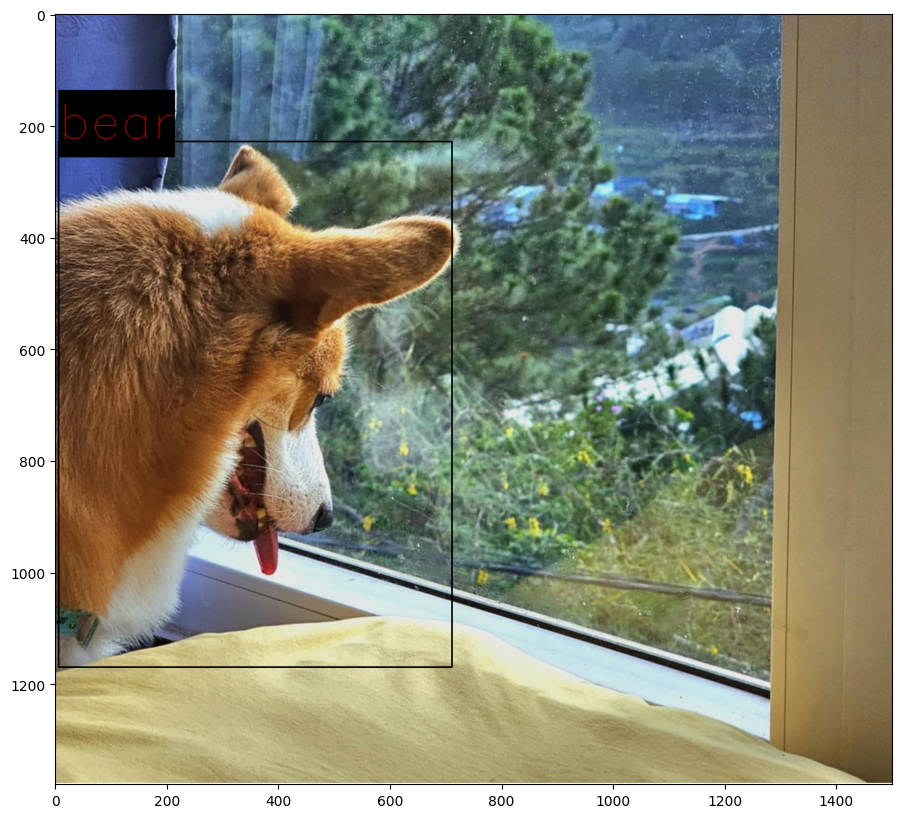

In [22]:
im = cv2.imread(os.path.join("images", "dog1.jpg"))
objects = detect_objects(net, im)
display_objects(im, objects)